In [3]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

import utils

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
! ls ../Feb9_2017

GluGluHToWW_Pt-200ToInf_M-125 TTToSemiLeptonic
QCD_Pt_1800to2400


# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- applies a specified preselection
- saves the combined dataframe under `events[ch][sample]`

In [39]:
year = "2017"
channels = ["mu", "ele"]

samples_dir = "../Feb9_2017"
samples = os.listdir(samples_dir)

combine_samples = {
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    
    # bkg
    "QCD_Pt": "QCD",
    "TT": "TTbar",
}

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

In [40]:
def apply_selection(preselection):

    events_dict = {}

    for ch in channels:

        events_dict[ch] = {}
        # get lumi
        with open("../fileset/luminosity.json") as f:
            luminosity = json.load(f)[ch][year]

        for sample in samples:

            ### get a combined label to combine samples of the same process
            for key in combine_samples:
                if key in sample:
                    sample_to_use = combine_samples[key]
                    break
                else:
                    sample_to_use = sample

            print(f"Finding {sample} samples and should combine them under {sample_to_use}")

            out_files = f"{samples_dir}/{sample}/outfiles/"
            parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            if not parquet_files:
                print(f"No parquet file for {sample}")
                continue                

            data = pd.read_parquet(parquet_files)
            not_empty = len(data) > 0

            # apply selection
            print("---> Applying preselection.")
            for selection in presel[ch]:
                print(f"applying {selection} selection on {len(data)} events")
                data = data.query(presel[ch][selection])
            print("---> Done with preselection.")

            # get event_weight
            print("---> Accumulating event weights.")                
            event_weight = utils.get_xsecweight(pkl_files, year, sample, False, luminosity)
            for w in weights[ch]:
                if w not in data.keys():
                    print(f"{w} weight is not stored in parquet")
                    continue
                event_weight *= data[w]
            data["event_weight"] = event_weight
            print("---> Done with accumulating event weights.")                       

            print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
            print(f"tot event weight {data['event_weight'].sum()} \n")

            # fill the big dataframe
            if sample_to_use not in events_dict[ch].keys():
                events_dict[ch][sample_to_use] = data
            else:
                events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])
    return events_dict

In [21]:
# alwayts true preselection
presel = {
    "mu": {
         "leptonKin": "(lep_pt > 0)",
    },
    "ele": {
         "leptonKin": "(lep_pt > 0)",
    }
}

events_dict_before_preselection = apply_selection(presel)

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Applying preselection.
applying leptonKin selection on 24213 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 21460 events
tot event weight 2367011.4932035427 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Applying preselection.
applying leptonKin selection on 69358 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the HWW dataframe with the remaining 63747 events
tot event weight 520.3026967957728 

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
applying leptonKin selection on 106281 events
---> Done with preselection.
---> Accumulating eve

<ipython-input-19-f798f618fe10>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-19-f798f618fe10>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-19-f798f618fe10>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [22]:
presel = {
    "mu": {
        # normal preselection
        "leptonKin": "(lep_pt > 30)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",        
        
#         # iso/miso experiments        
#         "mini-iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
#         "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
#         "iso": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    },
    "ele": {
        # normal preselection        
        "leptonKin": "(lep_pt > 40)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",
    }
}

events_dict_after_preselection = apply_selection(presel)

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Applying preselection.
applying leptonKin selection on 24213 events
applying fatjetKin selection on 21460 events
applying ht selection on 4093 events
applying oneLepton selection on 4093 events
applying notaus selection on 3876 events
applying leptonInJet selection on 2800 events
applying metfilters selection on 874 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 874 events
tot event weight 90298.70862244119 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Applying preselection.
applying leptonKin selection on 69358 events
applying fatjetKin selection on 63747 events
applying ht selection on 51946 events
applying oneLepton selection on 51899 events
applying notaus selection on 45040 events
applying leptonInJet se

<ipython-input-19-f798f618fe10>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-19-f798f618fe10>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-19-f798f618fe10>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

## PKU vs UCSD

In [25]:
# for direct comparisons, these must be overlooked
labels_to_be_removed = ['fj_ParT_probQCD', 'fj_ParT_probTopb', 'fj_ParT_probHWWelenuqq', 'fj_ParT_probHWWmunuqq']

UCSD_labels, PKU_labels = [], []    

for key in events_dict["mu"]["HWW"].keys():   # any sample will do
    if "prob" in key:      
        if "PKU" in key:
            PKU_labels.append(key)        
        elif ("ParT" in key):
            if key not in labels_to_be_removed:
                UCSD_labels.append(key)              

In [26]:
PKU_labels

['fj_PKU_ParT_probHWqqWqq0c',
 'fj_PKU_ParT_probHWqqWqq1c',
 'fj_PKU_ParT_probHWqqWqq2c',
 'fj_PKU_ParT_probHWqqWq0c',
 'fj_PKU_ParT_probHWqqWq1c',
 'fj_PKU_ParT_probHWqqWq2c',
 'fj_PKU_ParT_probHWqqWev0c',
 'fj_PKU_ParT_probHWqqWev1c',
 'fj_PKU_ParT_probHWqqWmv0c',
 'fj_PKU_ParT_probHWqqWmv1c',
 'fj_PKU_ParT_probHWqqWtauev0c',
 'fj_PKU_ParT_probHWqqWtauev1c',
 'fj_PKU_ParT_probHWqqWtaumv0c',
 'fj_PKU_ParT_probHWqqWtaumv1c',
 'fj_PKU_ParT_probHWqqWtauhv0c',
 'fj_PKU_ParT_probHWqqWtauhv1c',
 'fj_PKU_ParT_probHbb',
 'fj_PKU_ParT_probHcc',
 'fj_PKU_ParT_probHss',
 'fj_PKU_ParT_probHqq',
 'fj_PKU_ParT_probHtauhtaue',
 'fj_PKU_ParT_probHtauhtaum',
 'fj_PKU_ParT_probHtauhtauh',
 'fj_PKU_ParT_probQCDbb',
 'fj_PKU_ParT_probQCDcc',
 'fj_PKU_ParT_probQCDb',
 'fj_PKU_ParT_probQCDc',
 'fj_PKU_ParT_probQCDothers',
 'fj_PKU_ParT_probTopbWqq0c',
 'fj_PKU_ParT_probTopbWqq1c',
 'fj_PKU_ParT_probTopbWq0c',
 'fj_PKU_ParT_probTopbWq1c',
 'fj_PKU_ParT_probTopbWev',
 'fj_PKU_ParT_probTopbWmv',
 'fj_PKU_ParT

In [27]:
UCSD_labels

['fj_ParT_probHWqqWqq0c',
 'fj_ParT_probHWqqWqq1c',
 'fj_ParT_probHWqqWqq2c',
 'fj_ParT_probHWqqWq0c',
 'fj_ParT_probHWqqWq1c',
 'fj_ParT_probHWqqWq2c',
 'fj_ParT_probHWqqWev0c',
 'fj_ParT_probHWqqWev1c',
 'fj_ParT_probHWqqWmv0c',
 'fj_ParT_probHWqqWmv1c',
 'fj_ParT_probHWqqWtauev0c',
 'fj_ParT_probHWqqWtauev1c',
 'fj_ParT_probHWqqWtaumv0c',
 'fj_ParT_probHWqqWtaumv1c',
 'fj_ParT_probHWqqWtauhv0c',
 'fj_ParT_probHWqqWtauhv1c',
 'fj_ParT_probHbb',
 'fj_ParT_probHcc',
 'fj_ParT_probHss',
 'fj_ParT_probHqq',
 'fj_ParT_probHtauhtaue',
 'fj_ParT_probHtauhtaum',
 'fj_ParT_probHtauhtauh',
 'fj_ParT_probQCDbb',
 'fj_ParT_probQCDcc',
 'fj_ParT_probQCDb',
 'fj_ParT_probQCDc',
 'fj_ParT_probQCDothers',
 'fj_ParT_probTopbWqq0c',
 'fj_ParT_probTopbWqq1c',
 'fj_ParT_probTopbWq0c',
 'fj_ParT_probTopbWq1c',
 'fj_ParT_probTopbWev',
 'fj_ParT_probTopbWmv',
 'fj_ParT_probTopbWtauhv',
 'fj_ParT_probTopbWtauev',
 'fj_ParT_probTopbWtaumv']

In [28]:
len(PKU_labels)

37

In [29]:
len(UCSD_labels)

37

## Plot

In [30]:
relevant_labels = {
    "HWW": [
        "HWqqWev0c",
        "HWqqWev1c",
        "HWqqWmv0c",
        "HWqqWmv1c",
        "HWqqWtauev0c",
        "HWqqWtauev1c",
        "HWqqWtaumv0c",
        "HWqqWtaumv1c",
        "Htauhtaue",
        "Htauhtaum"
    ],
    "TTbar": [
        "TopbWqq0c",
        "TopbWqq1c",
        "TopbWq0c",
        "TopbWq1c",
        "TopbWev",
        "TopbWmv",
        "TopbWtauhv",
        "TopbWtauev",
        "TopbWtaumv"
    ],
    "QCD": [
        "QCDbb",
        "QCDcc",
        "QCDb",
        "QCDc", 
        "QCDothers"
    ]
}

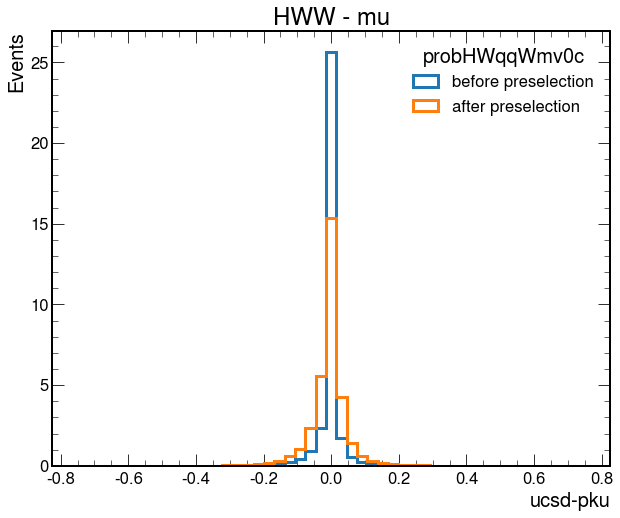

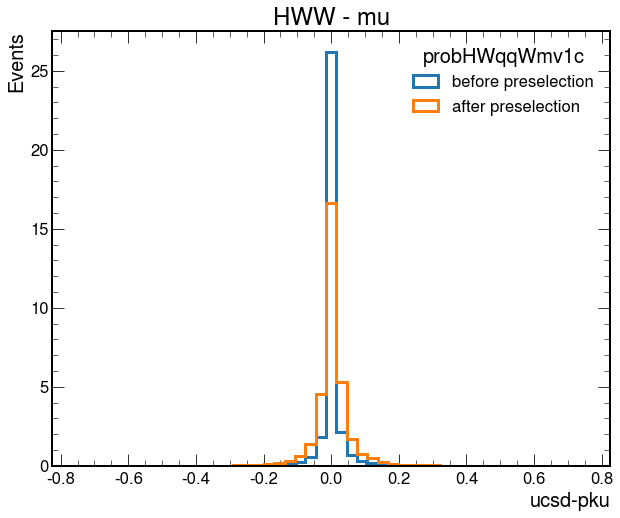

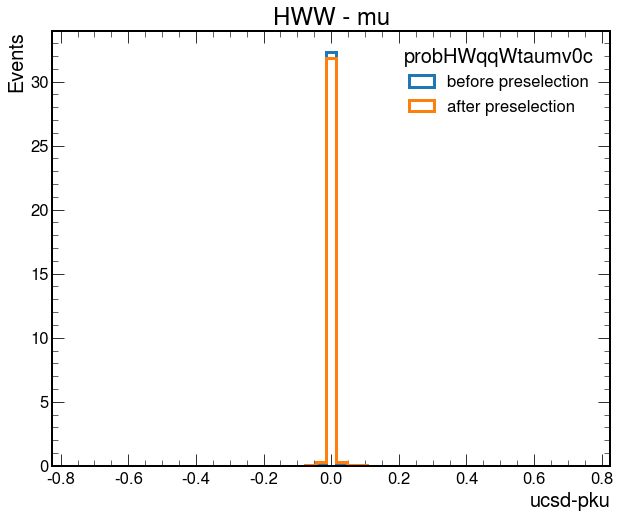

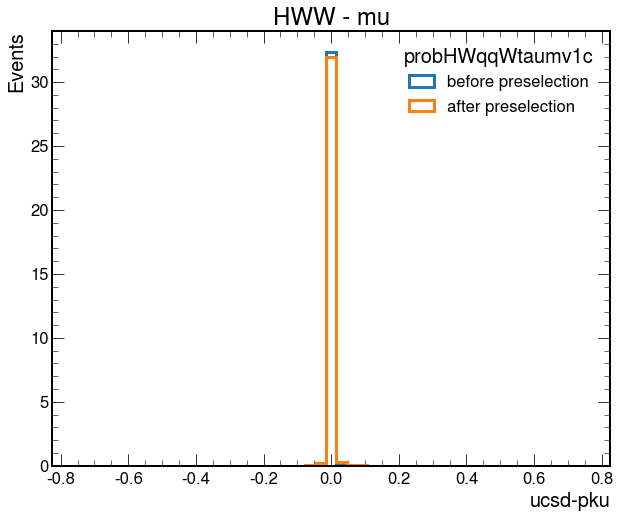

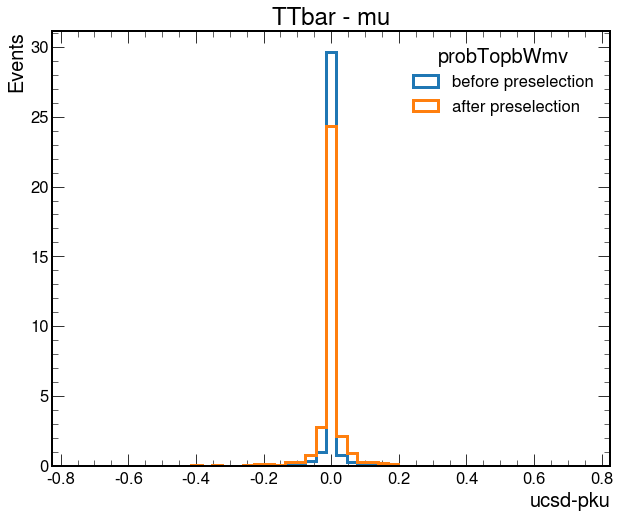

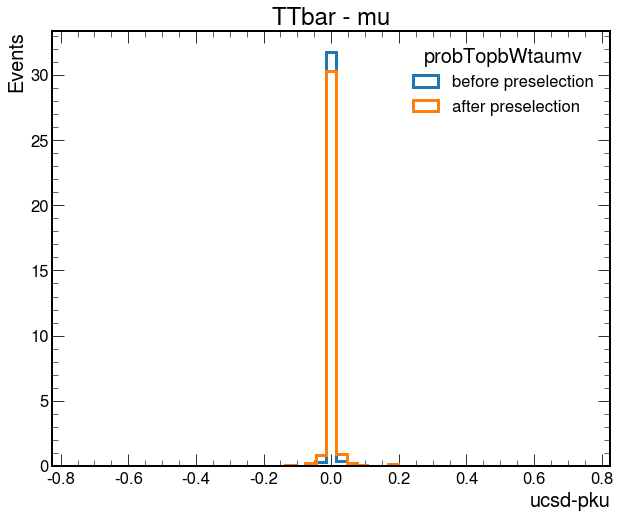

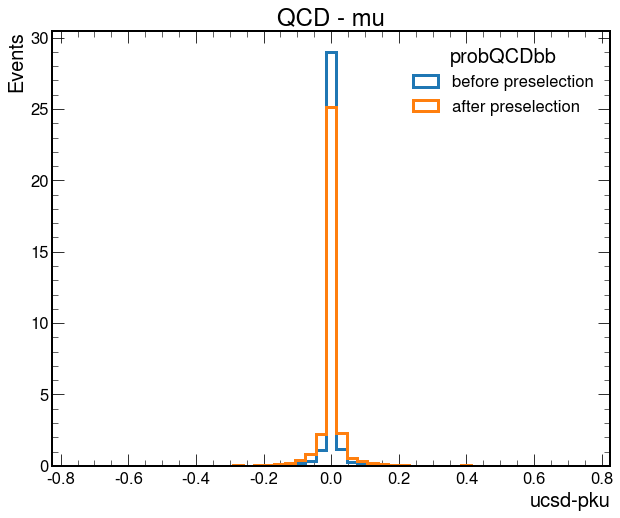

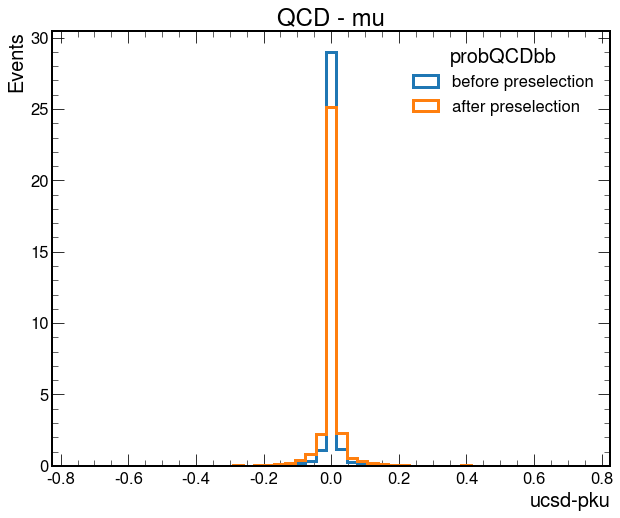

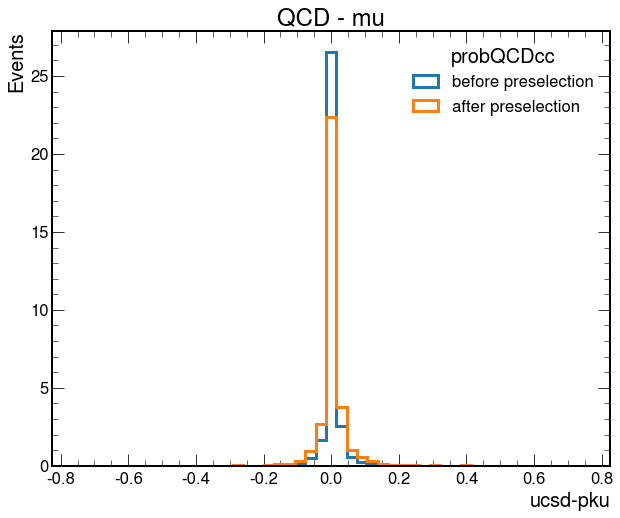

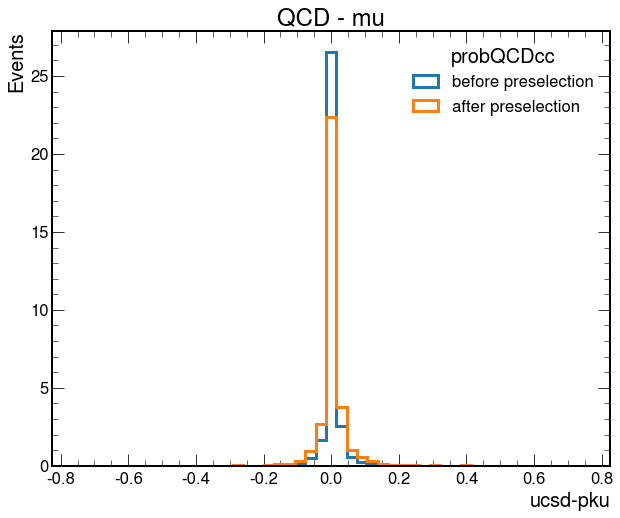

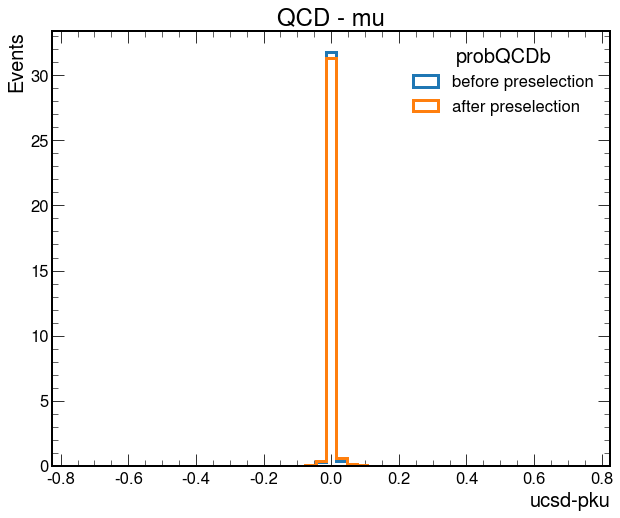

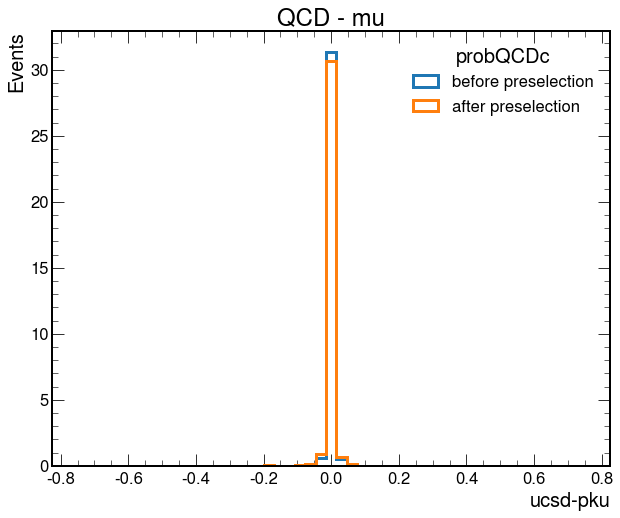

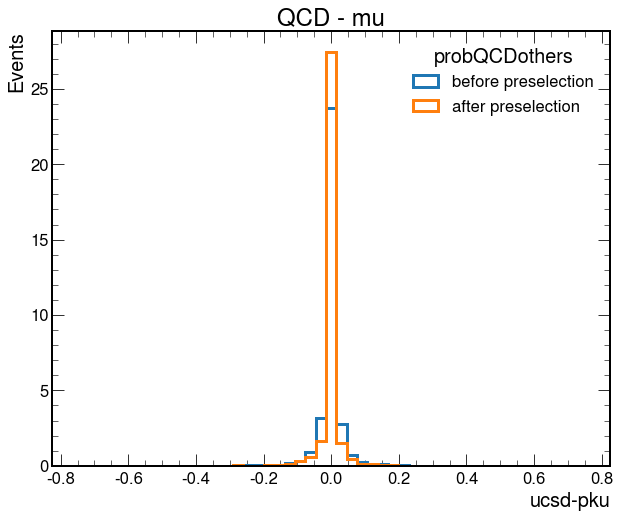

In [41]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

for ch in ["mu"]:#, "ele"]:
    if ch =="ele":
        test_ = "ev"
    else:
        test_ = "mv"
    
    for sample in samples_to_plot:

        for label_index, label in enumerate(UCSD_labels):
            
            for rel_label in relevant_labels[sample]:
                if rel_label in label:
                    
                    if (test_ in label) or (sample == "QCD"):
                        fig, ax = plt.subplots(figsize=(10, 8))

                        bins_ = np.linspace(-0.75,0.75,50)
                        
                        # plot resolution before preselection                        
                        ucsd_vals = events_dict_before_preselection[ch][sample][UCSD_labels[label_index]].values
                        pku_vals = events_dict_before_preselection[ch][sample][PKU_labels[label_index]].values

                        ax.hist(
                            ucsd_vals-pku_vals,
                            bins_,
                            label="before preselection",
                            linewidth=3,
                            density=True,
                            histtype="step"
                        )
                    
                        # plot resolution after preselection
                        ucsd_vals = events_dict_after_preselection[ch][sample][UCSD_labels[label_index]].values
                        pku_vals = events_dict_after_preselection[ch][sample][PKU_labels[label_index]].values
                        
                        ax.hist(
                            ucsd_vals-pku_vals,
                            bins_,
                            label="after preselection",
                            linewidth=3,
                            density=True,
                            histtype="step"
                        )
                                                
                        events_dict_before_preselection
                        
                        ax.set_title(f"{sample} - {ch}")
                        ax.legend(title=UCSD_labels[label_index][8:])
                        ax.set_ylabel("Events")
                        ax.set_xlabel("ucsd-pku")
#                         ax.set_yscale("log");

# Make ROCs

In [42]:
labels = {
    "label_H_WqqWqq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==0) )",
    "label_H_WqqWqq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==1) )",
    "label_H_WqqWqq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==2) )",
    "label_H_WqqWq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==0) )",
    "label_H_WqqWq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==1) )",
    "label_H_WqqWq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==2) )",
    "label_H_WW2lep": "(fj_lepinprongs==2)",
    "label_H_WW0lep": "(fj_lepinprongs==0)",
    "label_H_WqWev": "(fj_H_VV_elenuqq==1) & (fj_nprongs==1) & (fj_lepinprongs==1)",
    "label_H_WqWmv": "(fj_H_VV_munuqq==1) & (fj_nprongs==1) & (fj_lepinprongs==1)",
    "label_H_WqqWev_0c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWev_1c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWmv_0c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWmv_1c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtauev_0c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauev_1c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtaumv_0c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtaumv_1c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtauhv_0c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauhv_1c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    
    "label_Top_nob": "(fj_Top_bmerged==0)",
    "label_Top_bWqq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 2)  & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWqq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 2) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    "label_Top_bWq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    "label_Top_bWev": "( (fj_Top_elenu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWmv": "( (fj_Top_munu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtauhv": "( (fj_Top_hadtauvqq==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtauev": "( (fj_Top_leptauelvnu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtaumv": "( (fj_Top_leptaumuvnu==1) & (fj_Top_bmerged==1) )",
    
    "label_W_ev": "(fj_V_elenu==1) & (fj_lepinprongs==1)",
    "label_W_ev_0lep": "(fj_V_elenu==1) & (fj_lepinprongs==0)",
    "label_W_mv": "(fj_V_munu==1) & (fj_lepinprongs==1)",
    "label_W_mv_0lep": "(fj_V_munu==1) & (fj_lepinprongs==0)",
    "label_W_tauv": "(fj_V_taunu==1) & (fj_lepinprongs==1)",
    "label_W_tauv_0lep": "(fj_V_taunu==1) & (fj_lepinprongs==0)",
    "label_Z_2lep": "(fj_lepinprongs==2)",
    "label_Z_1lep": "(fj_lepinprongs==1)",
}

match_labels = {
    "HWW": "fj_H_VV_isMatched",
    "TTbar": "fj_Top_isMatched",
    "SingleTop": "fj_Top_isMatched",    
    "WJetsLNu": "fj_V_isMatched",
    "DYJets": "fj_V_isMatched",
}

In [34]:
presel = {
    "mu": {
         "leptonKin": "(lep_pt > 0)",

#         ## normal preselection
#         "leptonKin": "(lep_pt > 30)",
#         "fatjetKin": "(fj_pt > 200)",
#         "ht": "(ht > 200)",
#         "oneLepton": "(oneLepton)",
#         "notaus": "(notaus)",
#         "leptonInJet": "(leptonInJet)",
#         "metfilters": "(metfilters)",
        
        ## iso/miso experiments        
#         "mini-iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
#         "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
#         "iso": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    },
    "ele": {
         "leptonKin": "(lep_pt > 0)",
        
        ## normal preselection        
#         "leptonKin": "(lep_pt > 40)",
#         "fatjetKin": "(fj_pt > 200)",
#         "ht": "(ht > 200)",
#         "oneLepton": "(oneLepton)",
#         "notaus": "(notaus)",
#         "leptonInJet": "(leptonInJet)",
#         "metfilters": "(metfilters)",
    }
}

In [35]:
# aesthetics
nicex_scores = {
    "hww_vs_qcd": r"$\frac{H_{WqqW(\ell\tau)\nu}}{H_{WqqW(e\tau)\nu}+QCD}$",
    "hww_vs_top": r"$\frac{H_{WqqW(\ell\tau)\nu}}{H_{WqqW(e\tau)\nu}+Top_{bW(\ell\tau\nu)}}$",
}

nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

import matplotlib.colors as mcolors
color_by_label = {}
for i,label in enumerate(labels):
    color_by_label[label] = list(mcolors.TABLEAU_COLORS.values())[i%10]

color_by_label["unmatched"] = "r"

In [36]:
# labels to check per sample
labels_per_sample = {
    "ele": {
        "TTbar": [
            "label_Top_bWev",
            "label_Top_bWtauev",
            "label_Top_nob",
        ],    
        "HWW": [
            "label_H_WqqWev_0c","label_H_WqqWev_1c",
        ],
        "QCD": [],
    },
    "mu": {
        "TTbar": [
            "label_Top_bWmv",
            "label_Top_bWtaumv",
            "label_Top_nob",
        ],      
        "HWW": [
            "label_H_WqqWmv_0c","label_H_WqqWmv_1c",
            "label_H_WqqWtaumv_0c","label_H_WqqWtaumv_1c",
        ], 
        "QCD": [],
        }
}

In [37]:
# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]
tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]

# first list is the numerator and second list is the denominator
scores = {
    "ele": {
        "hww_vs_qcd": [hwwev,qcd],
        "hww_vs_top": [hwwev,tope],
    },
    "mu": {
        "hww_vs_qcd": [hwwmv,qcd],
        "hww_vs_top": [hwwmv,topm],
    }
                     
}

def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den


roc_labels = {}
roc_scores = {}

from sklearn.metrics import auc, roc_curve

PNs = ["ParT","PKU_ParT"]

for pn_version in PNs:
    pn_scores = {}
    roc_labels[pn_version] = {}
    roc_scores[pn_version] = {}
    for score,(sig,bkg) in scores[ch].items():
        new_sig = [s.replace("PN",pn_version) for s in sig]
        new_bkg = [s.replace("PN",pn_version) for s in bkg]
    
        pn_scores[score] = [new_sig,new_bkg]
        
        roc_labels[pn_version][score] = []
        roc_scores[pn_version][score] = []

    score_hists = {}
    for score in pn_scores.keys():
        score_hists[score] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 1, name="score", label=score)   
        )
        
    samples_to_process = ["HWW","QCD","TTbar"]#,"WJetsLNu"]
    samples = os.listdir(samples_dir)

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample
        
        if sample_to_use not in samples_to_process:
            continue
    
        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                
                               
        data = pd.read_parquet(parquet_files)
        not_empty = len(data) > 0

        # apply selection
#         print("---> Applying preselection.")
        for selection in presel[ch]:
#             print(f"applying {selection} selection on {len(data)} events")
            data = data.query(presel[ch][selection])  
#         print("---> Done with preselection.")

        # query labels from ucsd to match a pku label and save the column
        for label in labels_per_sample[ch][sample_to_use]:
            match_label = match_labels[sample_to_use]
            data[label] = data.query(labels[label])[match_label]            

        # fill NaN rows that didn't pass with False
        data.fillna(value=False,inplace=True)
                
        for score,(sigs,bkgs) in pn_scores.items():
            data[score] = disc_score(data,sigs,bkgs)
            
            # make hist
            score_hists[score].fill(samples=sample_to_use,score=data[score])

            if score=="hww_vs_qcd" and sample_to_use in ["HWW","QCD"]:
                if "QCD" in sample_to_use:
                    label = [0] * len(data["fj_pt"].tolist())
                else:
                    label = (data["label_H_WqqWmv_0c"] | data["label_H_WqqWmv_1c"] | data["label_H_WqqWtaumv_0c"] | data["label_H_WqqWtaumv_1c"]).tolist()
                roc_scores[pn_version][score] += data[score].tolist()                                
                roc_labels[pn_version][score] += label
                
            elif score=="hww_vs_top" and sample_to_use in ["HWW","TTbar"]:
                if "TTbar" in sample_to_use:
                    label = (data["label_Top_bWmv"] | data["label_Top_bWtaumv"] | data["label_Top_nob"]).tolist()
                else:
                    label = (data["label_H_WqqWmv_0c"] | data["label_H_WqqWmv_1c"] | data["label_H_WqqWtaumv_0c"] | data["label_H_WqqWtaumv_1c"]).tolist()
                roc_scores[pn_version][score] += data[score].tolist()                                
                roc_labels[pn_version][score] += label

Finding TTToSemiLeptonic samples and should combine them under TTbar
Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
Finding QCD_Pt_1800to2400 samples and should combine them under QCD
Finding TTToSemiLeptonic samples and should combine them under TTbar
Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
Finding QCD_Pt_1800to2400 samples and should combine them under QCD


Plotting hww_vs_qcd score
  For ParT model
Found 11810 NaN scores out of 75964. Will remove them.
  For PKU_ParT model
Found 11810 NaN scores out of 75964. Will remove them.
Plotting hww_vs_top score
  For ParT model
Found 29168 NaN scores out of 85207. Will remove them.
  For PKU_ParT model
Found 29168 NaN scores out of 85207. Will remove them.


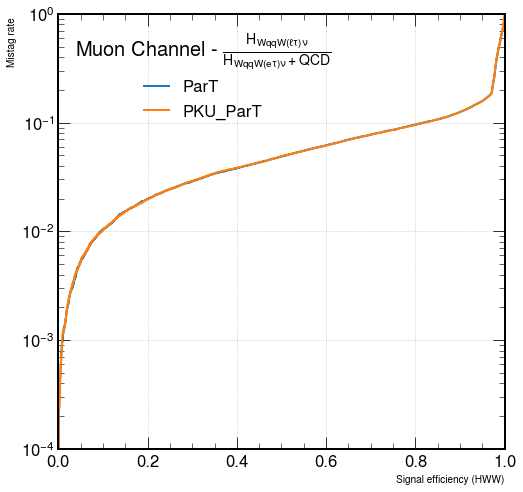

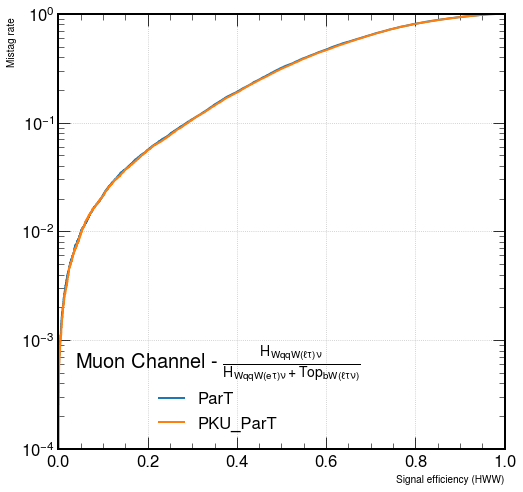

In [38]:
for score in scores[ch].keys():
    print(f"Plotting {score} score")
    fig, ax = plt.subplots(figsize=(8,8))
    ax.grid()
    for pn_version in PNs:
        print(f"  For {pn_version} model")
        
        labels_ = np.array(roc_labels[pn_version][score])
        scores_ = np.array(roc_scores[pn_version][score])

        is_nan = np.isnan(np.array(roc_scores[pn_version][score]))
        if is_nan.sum()!=0:
            print(f"Found {is_nan.sum()} NaN scores out of {len(scores_)}. Will remove them.")
            labels_ = labels_[~is_nan]
            scores_ = scores_[~is_nan]
            
        fpr, tpr, _ = roc_curve(labels_, scores_)
        ax.plot(tpr,fpr,linewidth=2,linestyle='solid',label=pn_version)
    ax.set_xlim(0, 1)
    ax.set_ylim(1e-4,1)
    ax.set_xlabel(f'Signal efficiency (HWW)', fontsize=10, ha='right', x=1)
    #ax.set_ylabel(f'Mistag rate (QCD+WJetsLNu+TT)', fontsize=10, ha='right', y=1)
    ax.set_ylabel(f'Mistag rate ', fontsize=10, ha='right', y=1)
    ax.set_yscale('log')
    xlab = nicex_scores[score]
    xch = nice_channel[ch]
    ax.legend(title=f"{xch} Channel - {xlab}")
#     ax.set_title("new iso/miso")